<a href="https://colab.research.google.com/github/victorsa2/sales_meli/blob/main/sales_meli.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exercício 1

## Preparando o Ambiente no Github

In [2]:
!git clone https://github.com/victorsa2/sales_meli.git

Cloning into 'sales_meli'...
remote: Enumerating objects: 92, done.
remote: Counting objects: 100% (92/92), done.
remote: Compressing objects: 100% (87/87), done.
remote: Total 92 (delta 40), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (92/92), 482.41 KiB | 3.01 MiB/s, done.
Resolving deltas: 100% (40/40), done.


## Subindo o arquivo .env com as variáveis no drive

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
from google.colab import files
uploaded = files.upload()

Saving .env to .env


##Instalando Dependencias não disponíveis no colab

In [5]:
pip install python-dotenv

In [6]:
import requests
import webbrowser
from dotenv import load_dotenv
import os

##Consultando API do Mercado Livre

##Obter Access Token e User ID

In [7]:
load_dotenv('/content/.env')

APP_ID = os.getenv("APP_ID")
APP_SECRET = os.getenv("APP_SECRET")
REDIRECT_URI = os.getenv("REDIRECT_URI")

def get_access_token_and_user_id():

    auth_url = f'https://auth.mercadolivre.com.br/authorization?response_type=code&client_id={APP_ID}&redirect_uri={REDIRECT_URI}'
    return auth_url

def request_token(authorization_code):
    token_url = 'https://api.mercadolibre.com/oauth/token'
    payload = {
        'grant_type': 'authorization_code',
        'client_id': os.getenv("APP_ID"),
        'client_secret': os.getenv("APP_SECRET"),
        'code': authorization_code,
        'redirect_uri': os.getenv("REDIRECT_URI")
    }

    response = requests.post(token_url, data=payload)
    token_data = response.json()

    access_token = token_data['access_token']
    user_id = token_data['user_id']

    return access_token, user_id

if __name__ == "__main__":
    auth_url = get_access_token_and_user_id()
    print("Abra o seguinte URL no seu navegador para obter o código de autorização:")
    print(auth_url)

    authorization_code = input("Insira o código de autorização: ")
    access_token, user_id = request_token(authorization_code)


Abra o seguinte URL no seu navegador para obter o código de autorização:
https://auth.mercadolivre.com.br/authorization?response_type=code&client_id=5500572046072825&redirect_uri=https://victorsa.netlify.app
Insira o código de autorização: TG-66fd3b81236f3100017302f4-478295390


##Obter dimensão de Categorias

In [8]:
import requests
import pandas as pd

def fetch_categories():
    url = "https://api.mercadolibre.com/sites/MLB/categories"
    response = requests.get(url)

    if response.status_code == 200:
        return response.json()
    else:
        print(f"Erro ao obter categorias: {response.status_code}")
        return []

categories_data = fetch_categories()
categories_list = []

for category in categories_data:
    categories_list.append({
        'id_category': category['id'],
        'name': category['name'],
    })

dim_Category = pd.DataFrame(categories_list)
dim_Category.to_csv('category.csv',encoding='utf-8-sig')

print("Dimensão Categorias:")
print(dim_Category.head())

Dimensão Categorias:
  id_category                      name
0     MLB5672  Acessórios para Veículos
1   MLB271599                      Agro
2     MLB1403       Alimentos e Bebidas
3     MLB1071                   Animais
4     MLB1367   Antiguidades e Coleções


## Consumindo API por produtos para conseguir alguns vendedores de exemplo, pesquisando por todas as categorias do Mercado Livre.


In [9]:
def fetch_categories():
    url = "https://api.mercadolibre.com/sites/MLB/categories"
    try:
        response = requests.get(url)
        response.raise_for_status()
        return response.json()
    except requests.exceptions.RequestException as e:
        print(f"Erro ao obter categorias: {e}")
        return []

def fetch_sales_in_category(category_id, access_token, site_id):
    url = f'https://api.mercadolibre.com/sites/{site_id}/search?category={category_id}'
    headers = {'Authorization': f'Bearer {access_token}'}

    try:
        response = requests.get(url, headers=headers)
        response.raise_for_status()
        return response.json()['results']
    except requests.exceptions.RequestException as e:
        print(f"Erro ao obter vendas na categoria {category_id}: {e}")
        return []

ACCESS_TOKEN = access_token
SITE_ID = 'MLB'

sales_list = []
categories_data = fetch_categories()

for category in categories_data:
    category_id = category['id']
    print(f"\nBuscando vendas na categoria: {category['name']} (ID: {category_id})")

    sales_data = fetch_sales_in_category(category_id, ACCESS_TOKEN, SITE_ID)

    if sales_data:
        for item in sales_data:
            if 'seller' in item and 'nickname' in item['seller']:
                sales_list.append({
                    'seller_id': item['seller']['id'],
                    'seller_nickname': item['seller']['nickname'],
                    'category_id': category['id'],
                    'category': category['name'],
                    'item_id': item['id'],
                    'item_name': item['title'],
                    'currency': item['currency_id'],
                    'price': item['price']
                })
    else:
        print("Nenhum resultado encontrado para esta categoria.")

df_sales = pd.DataFrame(sales_list)
df_sales.to_csv('products.csv',encoding='utf-8-sig')

print(df_sales)


Buscando vendas na categoria: Acessórios para Veículos (ID: MLB5672)

Buscando vendas na categoria: Agro (ID: MLB271599)

Buscando vendas na categoria: Alimentos e Bebidas (ID: MLB1403)

Buscando vendas na categoria: Animais (ID: MLB1071)

Buscando vendas na categoria: Antiguidades e Coleções (ID: MLB1367)

Buscando vendas na categoria: Arte, Papelaria e Armarinho (ID: MLB1368)

Buscando vendas na categoria: Bebês (ID: MLB1384)

Buscando vendas na categoria: Beleza e Cuidado Pessoal (ID: MLB1246)

Buscando vendas na categoria: Brinquedos e Hobbies (ID: MLB1132)

Buscando vendas na categoria: Calçados, Roupas e Bolsas (ID: MLB1430)

Buscando vendas na categoria: Câmeras e Acessórios (ID: MLB1039)

Buscando vendas na categoria: Carros, Motos e Outros (ID: MLB1743)

Buscando vendas na categoria: Casa, Móveis e Decoração (ID: MLB1574)
Erro ao obter vendas na categoria MLB1574: 534 Server Error: Unknown for url: https://api.mercadolibre.com/sites/MLB/search?category=MLB1574
Nenhum resultad

## Exploração e Tratamento

Adicionando o arquivo gerado pelo GPT no ambiente do colab

In [98]:
import pandas as pd

path_category = '/content/category.csv'
path_products = '/content/products.csv'

df_category = pd.read_csv(path_category, sep=',')
df_products = pd.read_csv(path_products, sep=',')

print('Informações dataframe Category:\n')
shape_category = df_category.info()

print('\nInformações dataframe Products:\n')
shape_products = df_products.info()

Informações dataframe Category:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32 entries, 0 to 31
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Unnamed: 0   32 non-null     int64 
 1   id_category  32 non-null     object
 2   name         32 non-null     object
dtypes: int64(1), object(2)
memory usage: 896.0+ bytes

Informações dataframe Products:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1431 entries, 0 to 1430
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Unnamed: 0       1431 non-null   int64  
 1   seller_id        1431 non-null   int64  
 2   seller_nickname  1431 non-null   object 
 3   category_id      1431 non-null   object 
 4   category         1431 non-null   object 
 5   item_id          1431 non-null   object 
 6   item_name        1431 non-null   object 
 7   currency         1431 non-null   object 
 8   

In [99]:
category_null = df_category.isnull().sum() > 0
print('Verificando nulos no dataframe Category:\n')
print(category_null)

products_null = df_products.isnull().sum() > 0
print('Verificando nulos no dataframe Products:\n')
print(products_null)

Verificando nulos no dataframe Category:

Unnamed: 0     False
id_category    False
name           False
dtype: bool
Verificando nulos no dataframe Products:

Unnamed: 0         False
seller_id          False
seller_nickname    False
category_id        False
category           False
item_id            False
item_name          False
currency           False
price              False
dtype: bool


In [100]:
df_price_null = df_products[df_products['price'].isnull()]
print('Linhas com valores nulos na coluna price:\n')
print(df_price_null)

Linhas com valores nulos na coluna price:

Empty DataFrame
Columns: [Unnamed: 0, seller_id, seller_nickname, category_id, category, item_id, item_name, currency, price]
Index: []



Retirando de todas as tabelas a categoria de "Serviços"

In [101]:
df_products = df_products[df_products['category'] != 'Serviços']
df_category = df_category[df_category['name'] != 'Serviços']

products_null = df_products.isnull().sum() > 0
print('Verificando nulos no dataframe Products:\n')
print(products_null)

Verificando nulos no dataframe Products:

Unnamed: 0         False
seller_id          False
seller_nickname    False
category_id        False
category           False
item_id            False
item_name          False
currency           False
price              False
dtype: bool


In [102]:
df_category = df_category.drop(['Unnamed: 0'], axis=1)
df_products = df_products.drop(['Unnamed: 0'], axis=1)

print(df_category)
print(df_products)

   id_category                         name
0      MLB5672     Acessórios para Veículos
1    MLB271599                         Agro
2      MLB1403          Alimentos e Bebidas
3      MLB1071                      Animais
4      MLB1367      Antiguidades e Coleções
5      MLB1368  Arte, Papelaria e Armarinho
6      MLB1384                        Bebês
7      MLB1246     Beleza e Cuidado Pessoal
8      MLB1132         Brinquedos e Hobbies
9      MLB1430    Calçados, Roupas e Bolsas
10     MLB1039         Câmeras e Acessórios
11     MLB1743       Carros, Motos e Outros
12     MLB1574     Casa, Móveis e Decoração
13     MLB1051        Celulares e Telefones
14     MLB1500                   Construção
15     MLB5726             Eletrodomésticos
16     MLB1000   Eletrônicos, Áudio e Vídeo
17     MLB1276           Esportes e Fitness
18   MLB263532                  Ferramentas
19    MLB12404       Festas e Lembrancinhas
20     MLB1144                        Games
21     MLB1459                  

In [103]:
df_products.to_csv('data_processed/products.csv',encoding='utf-8-sig')
df_category.to_csv('data_processed/category.csv',encoding='utf-8-sig')

##Criação do Banco de Dados SQLite

In [104]:
import sqlite3
import pandas as pd

conn_data = sqlite3.connect('db1.db')
cursor_data = conn_data.cursor()

In [105]:
# Criação da tabela Categoria

from prettytable import PrettyTable

table = PrettyTable(["id_category", "name"])

cursor_data.execute('''
    CREATE TABLE IF NOT EXISTS raw_category (
        id_category TEXT PRIMARY KEY,
        name TEXT NOT NULL
    )
''')

df_category.to_sql('raw_category', conn_data, if_exists='replace', index=False)

cursor_data.execute('SELECT * FROM raw_category')
rows = cursor_data.fetchall()

for row in rows:
    table.add_row(row)

print(table)


+-------------+-----------------------------+
| id_category |             name            |
+-------------+-----------------------------+
|   MLB5672   |   Acessórios para Veículos  |
|  MLB271599  |             Agro            |
|   MLB1403   |     Alimentos e Bebidas     |
|   MLB1071   |           Animais           |
|   MLB1367   |   Antiguidades e Coleções   |
|   MLB1368   | Arte, Papelaria e Armarinho |
|   MLB1384   |            Bebês            |
|   MLB1246   |   Beleza e Cuidado Pessoal  |
|   MLB1132   |     Brinquedos e Hobbies    |
|   MLB1430   |  Calçados, Roupas e Bolsas  |
|   MLB1039   |     Câmeras e Acessórios    |
|   MLB1743   |    Carros, Motos e Outros   |
|   MLB1574   |   Casa, Móveis e Decoração  |
|   MLB1051   |    Celulares e Telefones    |
|   MLB1500   |          Construção         |
|   MLB5726   |       Eletrodomésticos      |
|   MLB1000   |  Eletrônicos, Áudio e Vídeo |
|   MLB1276   |      Esportes e Fitness     |
|  MLB263532  |         Ferramenta

In [111]:
#Criando Tabela Produtos

table = PrettyTable(["seller_id", "seller_nickname", "category_id", "category", "item_id", "item_name", "currency", "price"])

cursor_data.execute('''
  CREATE TABLE IF NOT EXISTS raw_product (
      seller_id INTEGER PRIMARY KEY,
      seller_nickname TEXT NOT NULL,
      category_id TEXT NOT NULL,
      category TEXT NOT NULL,
      item_id TEXT NOT NULL,
      item_name TEXT NOT NULL,
      currency TEXT NOT NULL,
      price REAL NOT NULL
    )
''')

df_products.to_sql('raw_product', conn_data, if_exists='replace', index=False)

cursor_data.execute('SELECT * FROM raw_product \
                    LIMIT 5')
rows = cursor_data.fetchall()

for row in rows:
    table.add_row(row)

print(table)

+------------+-----------------+-------------+---------------------------+---------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------+----------+--------+
| seller_id  | seller_nickname | category_id |          category         |    item_id    |                                                                          item_name                                                                          | currency | price  |
+------------+-----------------+-------------+---------------------------+---------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------+----------+--------+
| 224160443  |  MAF UTILIDADES |   MLB5672   | AcessÃ³rios para VeÃ­culos | MLB4296308798 |                                               Kit 10 Panos Microfibra Flanela 35*50cm Power Clean Cor

In [107]:
cursor_data.execute('DROP TABLE IF EXISTS raw_vendas')

In [108]:
# Criar tabela de vendas

table = PrettyTable(["seller_id", "data_created", "item_id", "quantity", "price"])

cursor_data.execute('''
CREATE TABLE IF NOT EXISTS raw_vendas (
    seller_id INTEGER PRIMARY KEY,
    data_created INTEGER NOT NULL,
    item_id INTEGER NOT NULL,
    quantity INTEGER NOT NULL,
    price REAL NOT NULL
);
''')

vendas = pd.read_csv('/content/data_processed/sales_gpt.csv', sep=';')
vendas.to_sql('raw_vendas', conn_data, if_exists='replace', index=False)

cursor_data.execute('SELECT * FROM raw_vendas \
                    LIMIT 5')
rows = cursor_data.fetchall()

for row in rows:
    table.add_row(row)

print(table)

+------------+----------------------------+---------------+----------+--------+
| seller_id  |        data_created        |    item_id    | quantity | price  |
+------------+----------------------------+---------------+----------+--------+
| 224160443  | 2024-06-22 00:31:45.205367 | MLB4296308798 |    5     |  41.0  |
| 444816473  | 2023-10-20 00:31:45.205433 | MLB3698110641 |    6     |  82.5  |
| 1165626720 | 2024-01-06 00:31:45.205440 | MLB3494040092 |    7     | 184.23 |
| 1148569370 | 2024-06-18 00:31:45.205448 | MLB3721274157 |    8     | 575.0  |
| 183982918  | 2024-07-23 00:31:45.205456 | MLB1381132707 |    8     |  56.0  |
+------------+----------------------------+---------------+----------+--------+


In [112]:
cursor_data.execute('DROP VIEW IF EXISTS seller_dim')

In [113]:

cursor_data.execute('''
    CREATE VIEW IF NOT EXISTS seller_dim AS
    SELECT
        ROW_NUMBER() OVER(ORDER BY seller_id) AS id_seller,
        seller_id AS cod_seller,
        seller_nickname AS seller_name
    FROM (
        SELECT DISTINCT seller_id, seller_nickname
        FROM raw_product
    ) AS unique_sellers
''')

cursor_data.execute('SELECT * FROM seller_dim \
                      LIMIT 5')

seller_dim = cursor_data.fetchall()
seller_table = PrettyTable()
seller_table.field_names = ["ID Seller", "Cod Seller", "Seller Name"]

for row in seller_dim:
    seller_table.add_row(row)

print("Seller Dimension:")
print(seller_table)

Seller Dimension:
+-----------+------------+--------------------------+
| ID Seller | Cod Seller |       Seller Name        |
+-----------+------------+--------------------------+
|     1     |   153594   |  TEM_DE_TUDO_MULTI_SHOP  |
|     2     |  1520446   |        INDAAPARAS        |
|     3     |  1650894   |    LIVRARIA-BOA-NOITE    |
|     4     |  3920462   |    SEBO_PE_NA_ESTRADA    |
|     5     |  4938207   | LIVRARIA-GOSPEL-COMMERCE |
+-----------+------------+--------------------------+


In [114]:
cursor_data.execute('DROP VIEW IF EXISTS item_dim')

In [115]:
cursor_data.execute('''
    CREATE VIEW IF NOT EXISTS item_dim AS
    SELECT
        ROW_NUMBER() OVER(ORDER BY item_id) AS id_item,
        item_id AS cod_item,
        item_name,
        category_id AS cod_category,
        category AS category_name
    FROM (
        SELECT DISTINCT item_id, item_name, category_id, category
        FROM raw_product
    ) AS unique_items
''')

cursor_data.execute('SELECT * FROM item_dim \
                    LIMIT 10')
item_dim = cursor_data.fetchall()
item_table = PrettyTable()
item_table.field_names = ["ID Item", "Item ID", "Item Name", "Category_id", "name"]

for row in item_dim:
    item_table.add_row(row)

print("\nItem Dimension:")
print(item_table)


Item Dimension:
+---------+---------------+---------------------------------------------------------------+-------------+-----------+
| ID Item |    Item ID    |                           Item Name                           | Category_id |    name   |
+---------+---------------+---------------------------------------------------------------+-------------+-----------+
|    1    | MLB1028968851 |    2 Caixa TÃ©rmica D Isopor Capacidade 120 Litros C/dreno    |  MLB218519  | Ingressos |
|    2    | MLB1030948809 | Caixa TÃ©rmica D Isopor Capacidade 165 Litros C/dreno Isoterm |  MLB218519  | Ingressos |
|    3    | MLB1031202677 |      Copo 10ml Acrilico C/1000 Doce Ou Ceia, DegustaÃ§Ã£o     |  MLB218519  | Ingressos |
|    4    | MLB1033727890 | TaÃ§a De Champagne Em Acrilico Descartavel 150ml 150 Unidades |  MLB218519  | Ingressos |
|    5    | MLB1044540635 |   Lona De ProteÃ§Ã£o Transparente 4x50 Metros Media - 1 Rolo  |  MLB218519  | Ingressos |
|    6    | MLB1059927182 |  Marmita Po

In [116]:
cursor_data.execute('''
    CREATE VIEW IF NOT EXISTS category_dim AS
    SELECT
        ROW_NUMBER() OVER(ORDER BY id_category) AS id_category,
        id_category AS cod_category,
        name AS category_name
    FROM (
        SELECT DISTINCT id_category, name
        FROM raw_category
    ) AS unique_sellers
''')

cursor_data.execute('SELECT * FROM category_dim')

category_dim = cursor_data.fetchall()
category_table = PrettyTable()
category_table.field_names = ["id_category", "cod_category", "category_name"]

for row in category_dim:
    category_table.add_row(row)

print("\nItem Dimension:")
print(category_table)


Item Dimension:
+-------------+--------------+-----------------------------+
| id_category | cod_category |        category_name        |
+-------------+--------------+-----------------------------+
|      1      |   MLB1000    |  Eletrônicos, Áudio e Vídeo |
|      2      |   MLB1039    |     Câmeras e Acessórios    |
|      3      |   MLB1051    |    Celulares e Telefones    |
|      4      |   MLB1071    |           Animais           |
|      5      |   MLB1132    |     Brinquedos e Hobbies    |
|      6      |   MLB1144    |            Games            |
|      7      |   MLB1168    |  Música, Filmes e Seriados  |
|      8      |   MLB1182    |    Instrumentos Musicais    |
|      9      |   MLB1196    |  Livros, Revistas e Comics  |
|      10     |   MLB12404   |    Festas e Lembrancinhas   |
|      11     |   MLB1246    |   Beleza e Cuidado Pessoal  |
|      12     |   MLB1276    |      Esportes e Fitness     |
|      13     |   MLB1367    |   Antiguidades e Coleções   |
|      

In [117]:
cursor_data.execute('DROP VIEW IF EXISTS FACT_SALES')


In [118]:
cursor_data.execute('''
    CREATE VIEW FACT_SALES AS
        SELECT
          seller_dim.id_seller AS KEY1_NR_SELLER,
          item_dim.id_item AS KEY1_NR_ITEM,
          raw_vendas.data_created,
          raw_vendas.quantity,
          raw_vendas.price,
          raw_vendas.quantity * raw_vendas.price AS total_sold
        FROM
        raw_vendas
        LEFT OUTER JOIN seller_dim ON raw_vendas.seller_id = seller_dim.cod_seller
        LEFT OUTER JOIN item_dim ON raw_vendas.item_id = item_dim.cod_item

''')

cursor_data.execute('SELECT * FROM FACT_SALES \
                  LIMIT 5')
fact_sales = cursor_data.fetchall()

# Criar a tabela PrettyTable para exibir os resultados
fact_sales_table = PrettyTable()
fact_sales_table.field_names = ["KEY1_NR_SELLER", "KEY1_NR_ITEM", "Data Created", "Quantity", "Price", "Total Sold"]

for row in fact_sales:
    fact_sales_table.add_row(row)

print("\nFact Sales:")
print(fact_sales_table)


Fact Sales:
+----------------+--------------+----------------------------+----------+--------+------------+
| KEY1_NR_SELLER | KEY1_NR_ITEM |        Data Created        | Quantity | Price  | Total Sold |
+----------------+--------------+----------------------------+----------+--------+------------+
|      303       |     962      | 2024-06-22 00:31:45.205367 |    5     |  41.0  |   205.0    |
|      471       |     542      | 2023-10-20 00:31:45.205433 |    6     |  82.5  |   495.0    |
|      804       |     319      | 2024-01-06 00:31:45.205440 |    7     | 184.23 |  1289.61   |
|      798       |     565      | 2024-06-18 00:31:45.205448 |    8     | 575.0  |   4600.0   |
|      239       |      36      | 2024-07-23 00:31:45.205456 |    8     |  56.0  |   448.0    |
+----------------+--------------+----------------------------+----------+--------+------------+


In [27]:
conn_data.commit()

#Finalização Exercício 1

## Pergunta:

1.   Como você nomearia cada tabela e porque?
      - Para a organização dos dados, inicialmente, criei tabelas com o prefixo "raw", indicando que contêm dados brutos extraídos diretamente da API.

      Em seguida, projetei um Data Warehouse para ser consumido no Tableau, onde desenvolvi views para as Dimensões e a Tabela Fato. O plano inicial consistia em criar dois bancos: um para os dados crus, contendo as dimensões em formato de view, e outro para armazenar as tabelas com os dados já processados. Essa estrutura permitiria realizar consultas de maneira mais eficiente, evitando joins entre views, que podem impactar a performance.

      Contudo, devido ao pequeno volume de dados, decidi implementar tudo em um único banco de dados. As tabelas foram nomeadas para refletir suas funções e o tipo de dados que armazenam, facilitando a compreensão e manutenção do esquema.




# Exercício 2

## 1. No Colab Notebook, escreva consultas SQL para calcular: receita total, número de produtos vendidos e preço médio de venda por vendedor no banco de dados SQLite.

In [119]:
from prettytable import PrettyTable

query = """
WITH vendas_totais AS (
    SELECT
        seller_id,
        SUM(price * quantity) AS receita_total,
        SUM(quantity) AS numero_produtos_vendidos
    FROM
        raw_vendas
    GROUP BY
        seller_id
)
SELECT
    seller_id,
    receita_total,
    numero_produtos_vendidos,
    receita_total / numero_produtos_vendidos AS preco_medio_venda
FROM
    vendas_totais

ORDER BY
    preco_medio_venda DESC

LIMIT 5
;
"""

cursor_data.execute(query)
resultados = cursor_data.fetchall()

tabela = PrettyTable()
tabela.field_names = ["Vendedor ID", "Receita Total", "Número de Produtos Vendidos", "Preço Médio de Venda"]

for linha in resultados:
    tabela.add_row(linha)

print(tabela)


+-------------+---------------+-----------------------------+----------------------+
| Vendedor ID | Receita Total | Número de Produtos Vendidos | Preço Médio de Venda |
+-------------+---------------+-----------------------------+----------------------+
|  114830033  |    149900.0   |              1              |       149900.0       |
|  1080147331 |   2518200.0   |              18             |       139900.0       |
|  153645053  |   2101800.0   |              17             |  123635.29411764706  |
|  383403729  |    115999.0   |              1              |       115999.0       |
|  1115174467 |   1385880.0   |              12             |       115490.0       |
+-------------+---------------+-----------------------------+----------------------+


## 2.Além disso, identifique nas consultas qual é o produto mais vendido, o vendedor com maior faturamento e a evolução agregada das vendas ao longo do tempo segmentadas por categoria.

In [120]:
from prettytable import PrettyTable

# Consulta 1: Produto mais vendido
query_produto_mais_vendido = """
SELECT
    item_id,
    item_name,
    SUM(quantity) AS total_vendido
FROM
    raw_vendas

LEFT OUTER JOIN item_dim ON raw_vendas.item_id = item_dim.cod_item

GROUP BY
    item_id

ORDER BY
    total_vendido DESC
LIMIT 1;
"""

cursor_data.execute(query_produto_mais_vendido)
produto_mais_vendido = cursor_data.fetchone()

tabela_produto = PrettyTable()
tabela_produto.field_names = ["Produto ID", "Nome", "Total Vendido"]
tabela_produto.add_row(produto_mais_vendido)
print("Produto Mais Vendido:")
print(tabela_produto)

Produto Mais Vendido:
+---------------+--------------------------------------------------------------------+---------------+
|   Produto ID  |                                Nome                                | Total Vendido |
+---------------+--------------------------------------------------------------------+---------------+
| MLB4063179466 | Creatina Monohidratada 600g 100% Pura Soldiers Nutrition Sem Sabor |       32      |
+---------------+--------------------------------------------------------------------+---------------+


In [121]:
# Consulta 2: Vendedor com maior faturamento
query_vendedor_maior_faturamento = """
SELECT
    seller_id,
    seller_name,
    SUM(price * quantity) AS faturamento_total
FROM
    raw_vendas

LEFT OUTER JOIN seller_dim ON raw_vendas.seller_id = seller_dim.cod_seller

GROUP BY
    seller_id
ORDER BY
    faturamento_total DESC
LIMIT 1;
"""

cursor_data.execute(query_vendedor_maior_faturamento)
vendedor_maior_faturamento = cursor_data.fetchone()

tabela_vendedor = PrettyTable()
tabela_vendedor.field_names = ["Vendedor ID", "Vendedor", "Faturamento Total"]
tabela_vendedor.add_row(vendedor_maior_faturamento)
print("\nVendedor com Maior Faturamento:")
print(tabela_vendedor)




Vendedor com Maior Faturamento:
+-------------+----------------------------+-------------------+
| Vendedor ID |          Vendedor          | Faturamento Total |
+-------------+----------------------------+-------------------+
|  1080147331 | LLCARMULTIMARCASLLCARMULTI |     2518200.0     |
+-------------+----------------------------+-------------------+


In [124]:
# Consulta 3: Evolução agregada das vendas por categoria
query_evolucao_vendas = """
SELECT
    strftime('%Y-%m', data_created) AS periodo,
    raw_product.category,
    SUM(raw_vendas.price * raw_vendas.quantity) AS receita_total
FROM
    raw_vendas

LEFT OUTER JOIN raw_product ON raw_vendas.item_id = raw_product.item_id

GROUP BY
    periodo, category
ORDER BY
    periodo, category

LIMIT 5;
"""

# Executando e exibindo a evolução das vendas por categoria
cursor_data.execute(query_evolucao_vendas)
evolucao_vendas = cursor_data.fetchall()

tabela_evolucao = PrettyTable()
tabela_evolucao.field_names = ["Período", "Categoria", "Receita Total"]

for linha in evolucao_vendas:
    tabela_evolucao.add_row(linha)

print("\nEvolução Agregada das Vendas por Categoria:")
print(tabela_evolucao)


Evolução Agregada das Vendas por Categoria:
+---------+---------------------------+--------------------+
| Período |         Categoria         |   Receita Total    |
+---------+---------------------------+--------------------+
| 2023-10 |            None           | 56714.42000000001  |
| 2023-10 | AcessÃ³rios para VeÃ­culos |      3417.36       |
| 2023-10 |            Agro           | 14776.820000000002 |
| 2023-10 |    Alimentos e Bebidas    |       556.04       |
| 2023-10 | Antiguidades e ColeÃ§Ãµes |      13951.08      |
+---------+---------------------------+--------------------+


Este output não faz tanto sentido, para vermos a evolução das vendas, então vamos transformá-lo em um gráfico


<ipython-input-123-128b90dbd3bd>:38: UserWarning: Glyph 129 (\x81) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129 (\x81) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


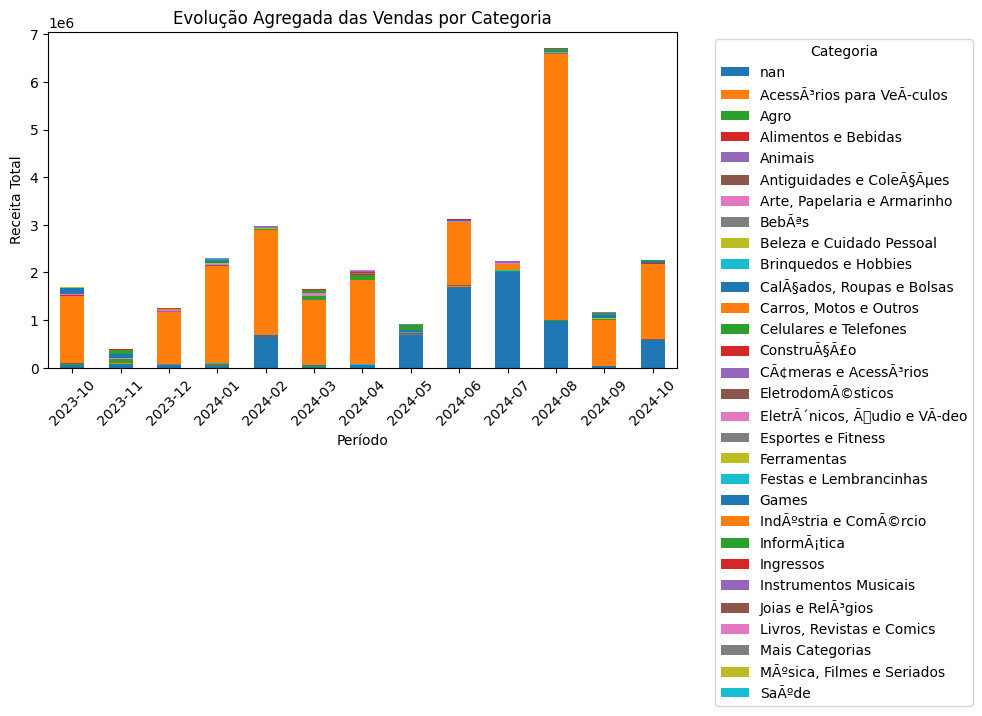

In [123]:
import matplotlib.pyplot as plt

# Consulta 3: Evolução agregada das vendas por categoria
query_evolucao_vendas = """
SELECT
    strftime('%Y-%m', data_created) AS periodo,
    raw_product.category,
    SUM(raw_vendas.price * raw_vendas.quantity) AS receita_total
FROM
    raw_vendas

LEFT OUTER JOIN raw_product ON raw_vendas.item_id = raw_product.item_id

GROUP BY
    periodo, category
ORDER BY
    periodo, category;
"""

cursor_data.execute(query_evolucao_vendas)
evolucao_vendas = cursor_data.fetchall()
df_evolucao_vendas = pd.DataFrame(evolucao_vendas, columns=["Período", "Categoria", "Receita Total"])

df_pivot = df_evolucao_vendas.pivot(index="Período", columns="Categoria", values="Receita Total")
df_pivot.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Evolução Agregada das Vendas por Categoria')
plt.xlabel('Período')
plt.ylabel('Receita Total')
plt.xticks(rotation=45)
plt.legend(title="Categoria", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

plt.show()
